In [22]:
# Import libraries
import os
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle

from skimage.feature import hog
from sklearn.svm import SVC

# Config display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [23]:
# Define image show function
def imageShow(data, convert = True, gray = False):
    if convert is True:
        data = data[:, :, ::-1] #RGB-> BGR
    if gray is True:
        color = 'gray'
    else:
        color = None
    plt.imshow(data, cmap = color)
    plt.axis('off')
    return plt.show()

In [24]:
# Sample image
imageFile = 'positive1.jpg'
xmlFile = 'positive1.xml'

imagePath = os.path.join(
    'data', 'leicaDetection', 'positive', 'image', imageFile
)

xmlPath = os.path.join(
    'data', 'leicaDetection', 'positive', 'annotation', xmlFile
)

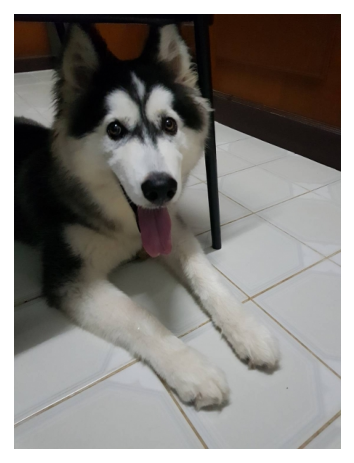

In [25]:
# Show sample image
image = cv2.imread(imagePath)
imageShow(image, convert = True, gray = False)

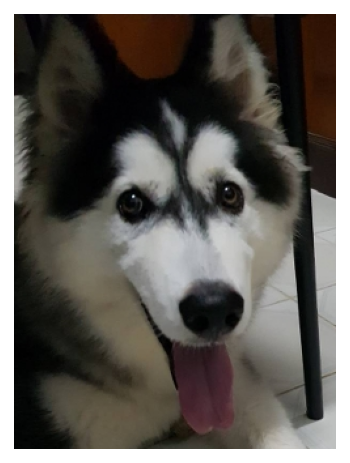

In [26]:
# Read .xml file for location of object
xml = ET.parse(xmlPath).getroot()
locations = xml.findall('object')

# Get object location
for location in locations:
    box = location.find('bndbox')
    x1 = int(float(box.find('xmin').text))
    y1 = int(float(box.find('ymin').text))
    x2 = int(float(box.find('xmax').text))
    y2 = int(float(box.find('ymax').text))

# Crop object from image
imageObject = image[y1:y2, x1:x2] #Vertical figure
imageShow(imageObject, convert = True, gray = False)

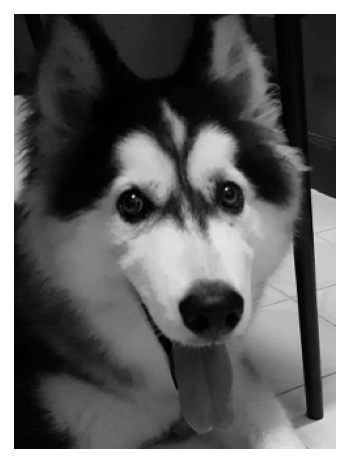

In [27]:
# Convert to gray scale
# Covert original to gray scale
imageGray = cv2.cvtColor(imageObject, cv2.COLOR_BGR2GRAY)
imageShow(imageGray, convert = False, gray = True)

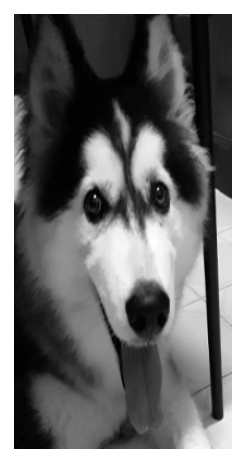

In [28]:
# Resize image to 2:1 (for HOG)
imageResize = cv2.resize(imageGray, (200, 400))
imageShow(imageResize, convert = False, gray = True)

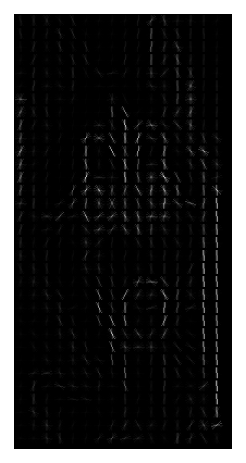

In [29]:
# Extract HOG
_, HOGImage = hog(
	imageResize,
	orientations = 9,
	pixels_per_cell = (12, 12),
	cells_per_block = (2, 2),
	visualize = True #Set to show image
)

imageShow(HOGImage, convert = False, gray = True)

In [30]:
# Define positive image processing function
def positiveImg(xmlPath, imagePath):
    # Read .xml file
    xml = ET.parse(xmlPath).getroot()
    locations = xml.findall('object')
    # Get object location
    for location in locations:
        box = location.find('bndbox')
        x1 = int(float(box.find('xmin').text))
        y1 = int(float(box.find('ymin').text))
        x2 = int(float(box.find('xmax').text))
        y2 = int(float(box.find('ymax').text))
    # Image processing
    img = cv2.imread(imagePath)
    img = img[y1:y2, x1:x2]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200, 400))
    # Extract HOG
    HOGImage = hog(
        img,
        orientations = 9,
        pixels_per_cell = (12, 12),
        cells_per_block = (2, 2),
        transform_sqrt = True,
        block_norm = 'L1',
        feature_vector = True
    )
    return HOGImage

In [31]:
# Define negative image processing function
def negativeImg(imagePath):
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200, 400))
    # Extract HOG
    HOGImage = hog(
        img,
        orientations = 9,
        pixels_per_cell = (12, 12),
        cells_per_block = (2, 2),
        transform_sqrt = True,
        block_norm = 'L1',
        feature_vector = True
    )
    return HOGImage

In [32]:
# Create dataset
# Positive image path
imagePos = sorted(
    os.listdir(
        os.path.join(
            'data', 'leicaDetection', 'positive', 'image'
        )
    )
)

annotations = sorted(
    os.listdir(
        os.path.join(
            'data', 'leicaDetection', 'positive', 'annotation'
        )
    )
)

imageNeg = sorted(
    os.listdir(
        os.path.join(
            'data', 'leicaDetection', 'negative'
        )
    )
)

data = []

# Positive images
for image, annotation in zip(imagePos[1:], annotations[1:]):
    xmlPath = os.path.join(
        'data', 'leicaDetection', 'positive', 'annotation', annotation
    )
    imagePath = os.path.join(
        'data', 'leicaDetection', 'positive', 'image', image
    )
    imageFile = positiveImg(xmlPath, imagePath)
    data.append([imageFile, 1])

# Negative images
for image in imageNeg[1:]:
    imagePath = os.path.join(
        'data', 'leicaDetection', 'negative', image
    )
    imageFile = negativeImg(imagePath)
    data.append([imageFile, 0])


In [33]:
# Random shuffle dataset
random.shuffle(data)

# Features and target split
features = []
labels = []

for feature, label in data:
  features.append(feature)
  labels.append(label)

# Convert to numpy array
features = np.array(features, dtype = 'float32')
labels = np.array(labels)

# Export dataset
pickle.dump(features, open('HOCLeica.pk', 'wb'))
pickle.dump(labels, open('labelLeica.pk', 'wb'))

In [34]:
# SVM using Support Vector Classifier (SVC)
model = SVC()
model.fit(features, labels)

print(f'Accuracy score: {model.score(features, labels) * 100:.2f}%')

Accuracy score: 100.00%


In [35]:
# Export model
pickle.dump(model, open('modelHOGLeica.pk', 'wb'))

In [36]:
# Define sliding window
def slidingWindow(image, stepSize, windowSize):
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Modified negative image processing function
def processImg(image):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (200, 400))
    # Extract HOG (Same as development)
    HOGImage = hog(
        img,
        orientations = 9,
        pixels_per_cell = (12, 12),
        cells_per_block = (2, 2),
        transform_sqrt = True,
        block_norm = 'L1',
        feature_vector = True
    )
    return HOGImage

# Define Non-Maximum Suppression
def nonMaxS(boxes, overlap):
    if len(boxes) == 0:
        return print('Cannot find the object')
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    # Find area of the box
    areas = (x2 - x1 + 1) * (y2 - y1 + 1) #+1 for at least 1 pixel
    indices = np.arange(len(x1)) #Create index range
    # Find possible range
    for i, box in enumerate(boxes):
        index = indices[indices != i] #Drop current position
        xx1 = np.maximum(box[0], boxes[index, 0]) #Compare with other position
        yy1 = np.maximum(box[1], boxes[index, 1])
        xx2 = np.minimum(box[2], boxes[index, 2])
        yy2 = np.minimum(box[3], boxes[index, 3]) #Return with condition array
        # Calculate height and width
        w = np.maximum(0, xx2 - xx1 + 1) #+1 for at least 1 pixel
        h = np.maximum(0, yy2 - yy1 + 1)
        # Calculate overlap ratio
        overlapValue = (w * h) / areas[index]
        if np.any(overlapValue) > overlap:
            indices = indices[indices != i] #More than threshold will be eliminated
    return boxes[indices][0].astype(int)

In [37]:
# Define parameters
w = 200
h = 200
steps = 30

# Define detection function
def objectDetection(image, steps, w, h, decisionThreshold, overlap):
    allDetections = []
    for (x, y, window) in slidingWindow(imageTest, stepSize = steps, windowSize = (h, w)):
        test = processImg(window)
        decision = model.decision_function(test.reshape(1, -1))[0] #Predict with decision
        if decision > decisionThreshold:
            allDetections.append([x, y, x + w, y + h])
    allDetections = np.array(allDetections) #To numpy
    detected = nonMaxS(allDetections, overlap)
    imageResult = image.copy()
    cv2.rectangle(
        imageResult,
        (detected[0], detected[1]),
        (detected[2], detected[3]),
        (0, 255, 0),
        2
    )
    plt.imshow(imageResult[:, :, ::-1])
    plt.axis('off')
    return plt.show()

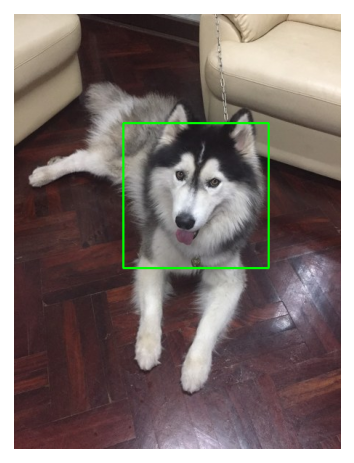

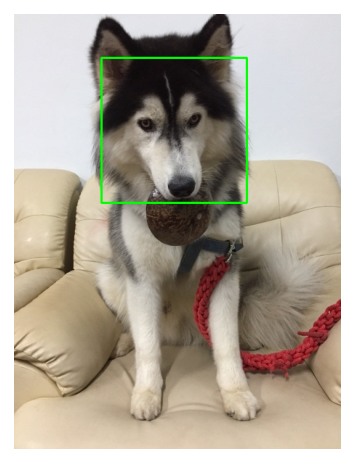

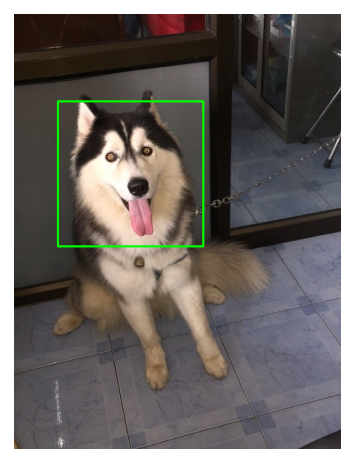

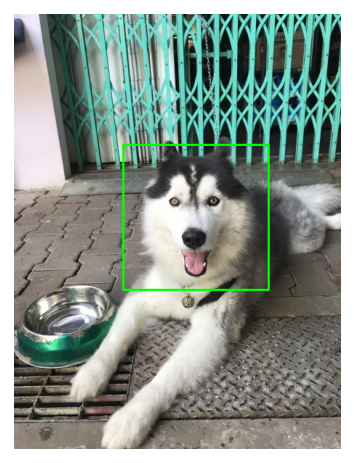

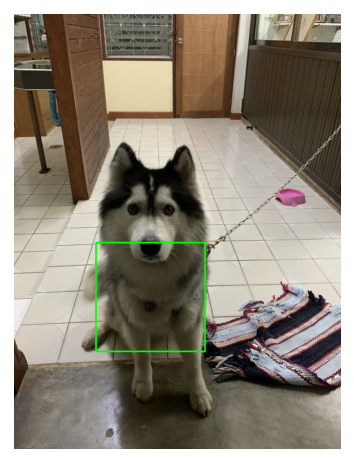

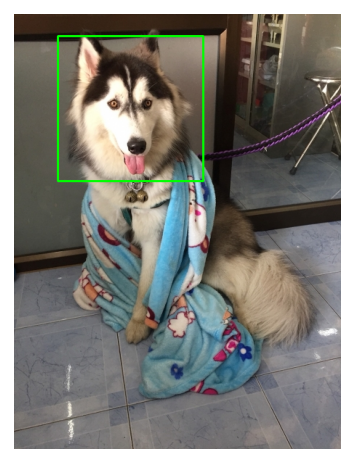

In [38]:
# Detection
filesTest = [file for file in os.listdir(os.path.join('data', 'leicaDetection')) if file.endswith(('.JPG', '.jpg'))]

for image in filesTest:
    imageTest = cv2.imread(os.path.join('data', 'leicaDetection', image))
    objectDetection(imageTest, 30, 200, 200, 0.8, 0.8)